<a href="https://colab.research.google.com/github/w95wayne10/computer_vision/blob/master/summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import numpy as np
from mask import J, K, octogonal_kernel, N, LoG_mtx, DoG_mtx
from cv_method import grouping, group_marking, \
                      Dilation, Erosion, Opening, Closing, \
                      gray_level_value_count_chart, gray_hist_equalization, \
                      f, thinning_one_step, \
                      BoxFilter, MedianFilter, \
                      Robert_Operator, Prewitt_Edge_Detector, Sobel_Operator, \
                      FreiChen_Gradient_Operator, Kirsch_Compass_Operator, \
                      Robinson_Compass_Operator, Nevatia_Babu_5x5_operator, \
                      Laplace_Mask1, Laplace_Mask2, Minimum_variance_Laplacian,\
                      Laplacian_of_Gaussian, Difference_of_Gaussian, zero_crossing

from google.colab.patches import cv2_imshow

In [3]:
# 讀檔
lena_gray = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)
cv2_imshow(lena_gray)

In [ ]:
# 變更順序達到旋轉鏡射等效果
upside_down_lena = lena_gray[::-1, :]
rightside_left_lena = lena_gray[:, ::-1]
diagonally_flip_lena = lena_gray.T

cv2_imshow(upside_down_lena)
cv2_imshow(rightside_left_lena)
cv2_imshow(diagonally_flip_lena)
#cv2.imwrite('upside_down_lena.bmp', upside_down_lena)
#cv2.imwrite('rightside_left_lena.bmp', rightside_left_lena)
#cv2.imwrite('diagonally_flip_lena.bmp', diagonally_flip_lena)

In [ ]:
# 二元化
binarize_lena = lena_gray//128*255
cv2_imshow(binarize_lena)
#cv2.imwrite('binarize_lena.bmp', binarize_lena)

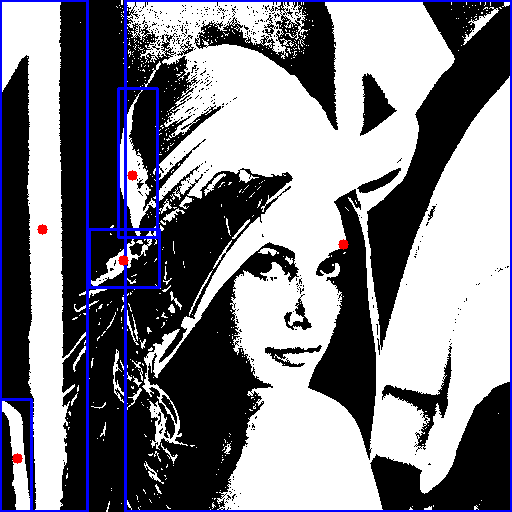

In [ ]:
# 分群
# 1. 分析
IDlist = grouping(binarize_lena)
# 2. 圖上標記

cv2_imshow(group_marking(binarize_lena, IDlist))
# cv2.imwrite('group_of_lena.bmp', image)

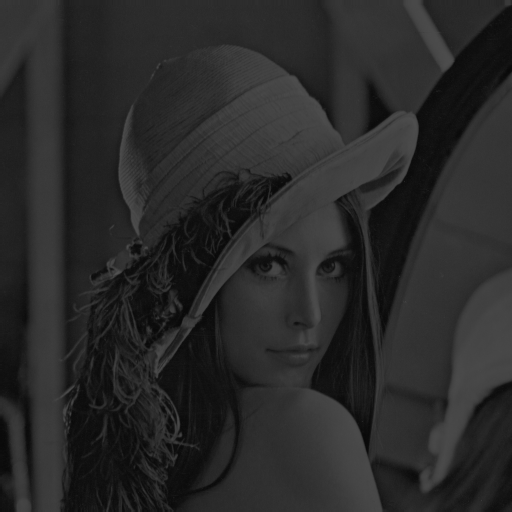

In [ ]:
divid_3_lena_gray = np.uint8(np.rint(lena_gray/3))

cv2_imshow(divid_3_lena_gray)
#cv2.imwrite('divid_3_lena_gray.bmp', divid_3_lena_gray)

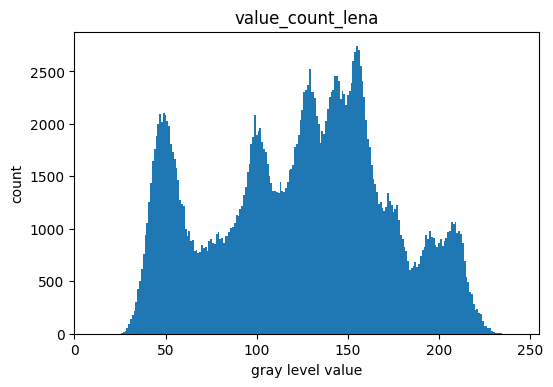

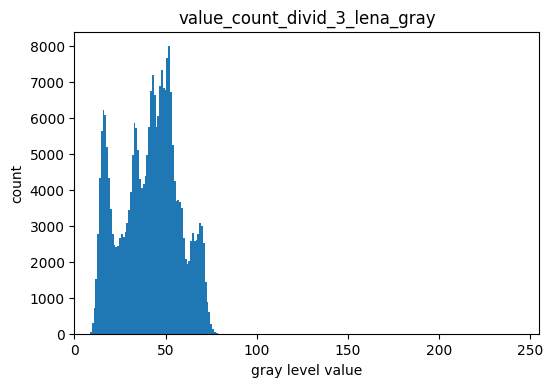

In [ ]:
# 灰階圖的色階統計
gray_level_value_count_chart(lena_gray, 'value_count_lena.png')
gray_level_value_count_chart(divid_3_lena_gray, 'value_count_divid_3_lena_gray.png')

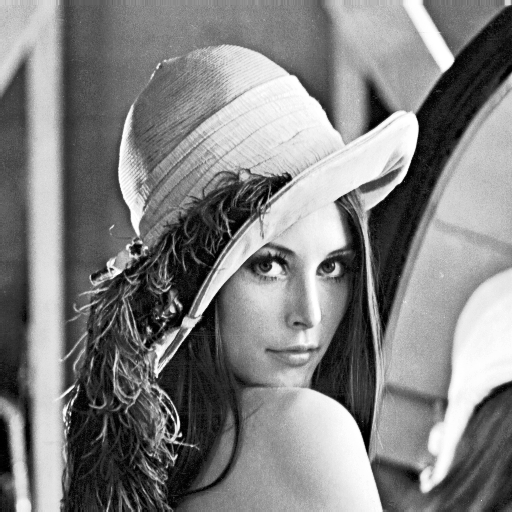

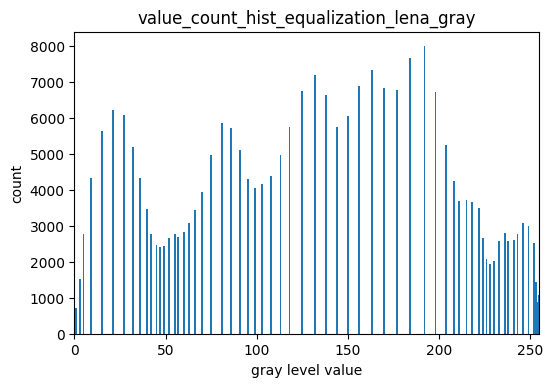

In [ ]:
hist_equalization_lena_gray = gray_hist_equalization(divid_3_lena_gray)
cv2_imshow(hist_equalization_lena_gray)
#cv2.imwrite('hist_equalization_lena_gray.bmp', hist_equalization_lena_gray)
gray_level_value_count_chart(hist_equalization_lena_gray, 'value_count_hist_equalization_lena_gray.png')

In [ ]:
JErosion = Erosion(binarize_lena, J)
KErosion = Erosion(255-binarize_lena, K)
HitandMiss_binarize_lena = ((JErosion > 128)&(KErosion > 128))*255

cv2_imshow(HitandMiss_binarize_lena)
#cv2.imwrite('HitandMiss_binarize_lena.bmp', HitandMiss_binarize_lena)

In [ ]:
Dilation_binarize_lena = Dilation(binarize_lena, octogonal_kernel)
Erosion_binarize_lena = Erosion(binarize_lena, octogonal_kernel)
Opening_binarize_lena = Dilation(Erosion_binarize_lena, octogonal_kernel)
Closing_binarize_lena = Erosion(Dilation_binarize_lena, octogonal_kernel)

cv2_imshow(Dilation_binarize_lena)
cv2_imshow(Erosion_binarize_lena)
cv2_imshow(Opening_binarize_lena)
cv2_imshow(Closing_binarize_lena)
#cv2.imwrite('Dilation_binarize_lena.bmp', Dilation_binarize_lena)
#cv2.imwrite('Erosion_binarize_lena.bmp', Erosion_binarize_lena)
#cv2.imwrite('Opening_binarize_lena.bmp', Opening_binarize_lena)
#cv2.imwrite('Closing_binarize_lena.bmp', Closing_binarize_lena)

In [ ]:
Dilation_lena = Dilation(lena_gray, octogonal_kernel)
Erosion_lena = Erosion(lena_gray, octogonal_kernel)
Opening_lena = Dilation(Erosion_lena, octogonal_kernel)
Closing_lena = Erosion(Dilation_lena, octogonal_kernel)


cv2_imshow(Dilation_lena)
cv2_imshow(Erosion_lena)
cv2_imshow(Opening_lena)
cv2_imshow(Closing_lena)
#cv2.imwrite('Dilation_lena.bmp', Dilation_lena)
#cv2.imwrite('Erosion_lena.bmp', Erosion_lena)
#cv2.imwrite('Opening_lena.bmp', Opening_lena)
#cv2.imwrite('Closing_lena.bmp', Closing_lena)

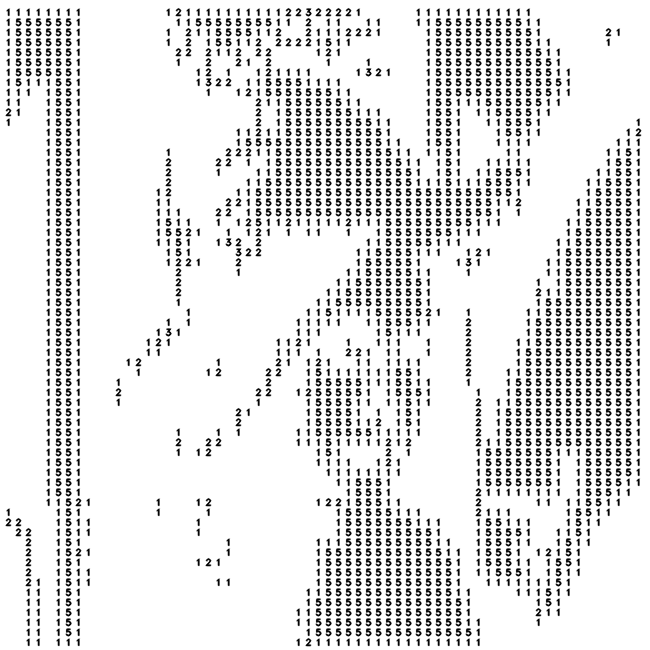

In [ ]:
binarize64_lena = np.zeros((64,64))
for r in range(64):
  for c in range(64):
    binarize64_lena[r,c] = binarize_lena[r*8,c*8]
check_table = np.zeros((66,66))
check_table[1:-1,1:-1] = binarize64_lena


img = np.zeros((650, 650, 3), np.uint8)
img.fill(255)
result = np.zeros((64,64))
for r in range(64):
  for c in range(64):
    if check_table[r+1,c+1]>254:
      result[r,c] = f(check_table[r:r+3,c:c+3])
      if int(np.around(result[r,c]))>0:
        cv2.putText(img, str(int(np.around(result[r,c]))), (c*10+5,r*10+15), cv2.FONT_HERSHEY_DUPLEX, 0.3, (0, 0, 0), 1, cv2.LINE_AA)

cv2_imshow(img)
# cv2.imwrite('img.bmp', img)

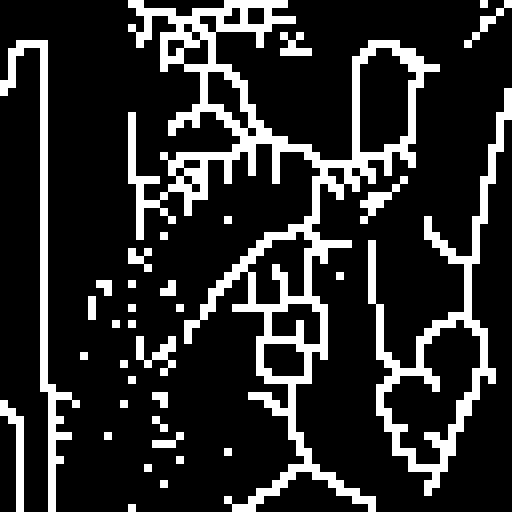

In [ ]:
binarize64_lena = np.zeros((64,64))
for r in range(64):
  for c in range(64):
    binarize64_lena[r,c] = binarize_lena[r*8,c*8]



org_lena = binarize64_lena
new_lena = thinning_one_step(org_lena)
#cv2_imshow(cv2.resize(new_lena, (512,512), interpolation = cv2.INTER_AREA))
while not np.array_equal(org_lena, new_lena):
  org_lena = new_lena
  new_lena = thinning_one_step(org_lena)
  #cv2_imshow(cv2.resize(new_lena, (512,512), interpolation = cv2.INTER_AREA))

#cv2_imshow(new_lena)
cv2_imshow(cv2.resize(new_lena, (512,512), interpolation = cv2.INTER_AREA))
#cv2.imwrite('new_lena.bmp', new_lena)

In [ ]:
N = lena_gray.shape[0]*lena_gray.shape[1]
mu_s = np.sum(lena_gray)/N
VS = np.sum((lena_gray-mu_s)**2)/N

noise_img_dict = {}
for method in ["g", "sp"]:
  for level in range(2):
    if method == "g":
      amplitude = 10 if level==0 else 30
      noise = amplitude * np.random.normal(0,1,lena_gray.shape)
      noise_img = np.around(lena_gray + noise)
      noise_img[noise_img>255] = 255
      noise_img[noise_img<0] = 0
      noise_img_dict["Gnoise"+str(amplitude)] = np.uint8(noise_img)
    else:
      prob = 0.05 if level==0 else 0.1
      noise_value = np.random.uniform(0,1,lena_gray.shape)
      noise_img = lena_gray.copy()
      noise_img[noise_value>=(1-prob)] = 255
      noise_img[noise_value<=prob] = 0
      noise_img_dict["SPnoise"+str(prob).replace(".", "")+("0" if level==1 else "")] = noise_img

for NIname, img in noise_img_dict.items():
  mu_n = np.sum(img-lena_gray)/N
  VN = np.sum((img-lena_gray-mu_n)**2)/N
  SNR = 20*np.log10(np.sqrt(VS)/np.sqrt(VN))
  print(NIname+", SNR="+str(SNR))
  cv2_imshow(img)
  #cv2.imwrite(NIname+".bmp", img)

for NIname, img in noise_img_dict.items():
  for method in ["Box", "Median", "OandC"]:
    for case in range(2):
      if method in ["Box", "Median"]:
        size = 3 if case == 0 else 5
        result = BoxFilter(img, size) if method=="Box" else MedianFilter(img, size)
        Rname = NIname+"_"+method+str(size)+"x"+str(size)
      else:
        methodName = "OthenC" if case==0 else "CthenO"
        result = Closing(Opening(img, octogonal_kernel), octogonal_kernel) if case==0 else Opening(Closing(img, octogonal_kernel), octogonal_kernel)
        Rname = NIname+"_"+methodName
      mu_n = np.sum(result-lena_gray)/N
      VN = np.sum((result-lena_gray-mu_n)**2)/N
      SNR = 20*np.log10(np.sqrt(VS)/np.sqrt(VN))
      print(Rname+", SNR="+str(SNR))
      cv2_imshow(result)
      #cv2.imwrite(Rname+".bmp",result)

In [ ]:
result = Robert_Operator(lena_gray, 12)
cv2_imshow(result)
#cv2.imwrite("Robert_Operator_12.bmp", result)
result = Robert_Operator(lena_gray, 30)
cv2_imshow(result)
#cv2.imwrite("Robert_Operator_30.bmp", result)
result = Prewitt_Edge_Detector(lena_gray, 24)
cv2_imshow(result)
#cv2.imwrite("Prewitt_Edge_Detector_24.bmp", result)
result = Sobel_Operator(lena_gray, 38)
cv2_imshow(result)
#cv2.imwrite("Sobel_Operator_38.bmp", result)
result = FreiChen_Gradient_Operator(lena_gray, 30)
cv2_imshow(result)
#cv2.imwrite("FreiChen_Gradient_Operator_30.bmp", result)
result = Kirsch_Compass_Operator(lena_gray, 135)
cv2_imshow(result)
#cv2.imwrite("Kirsch_Compass_Operator_135.bmp", result)
result = Robinson_Compass_Operator(lena_gray, 43)
cv2_imshow(result)
#cv2.imwrite("Robinson_Compass_Operator_43.bmp", result)
result = Nevatia_Babu_5x5_operator(lena_gray, 12500)
cv2_imshow(result)
#cv2.imwrite("Nevatia_Babu_5x5_operator_12500.bmp", result)

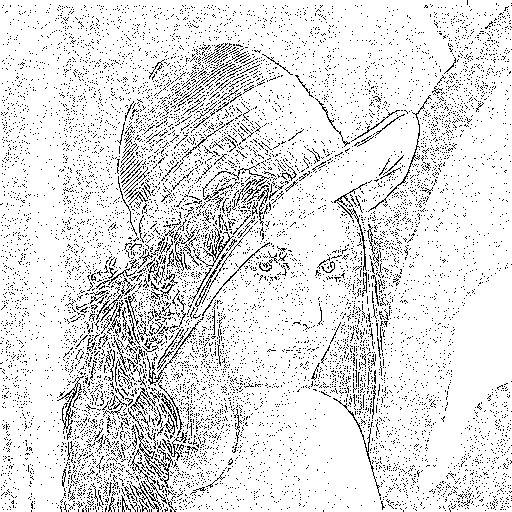

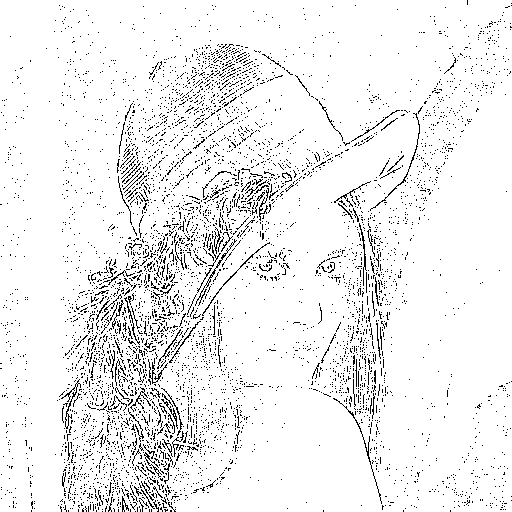

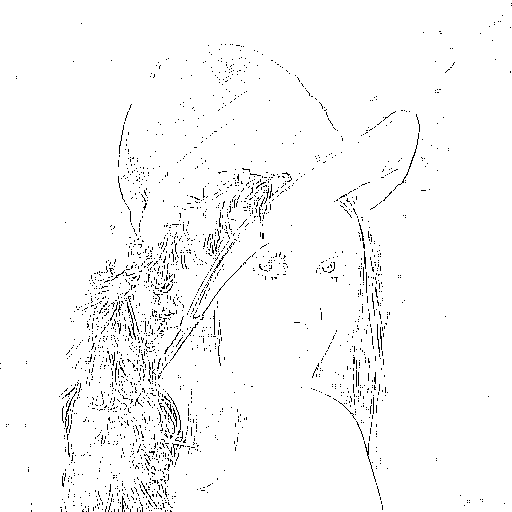

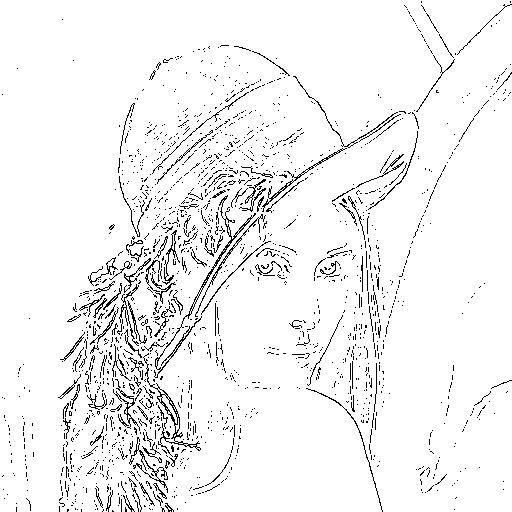

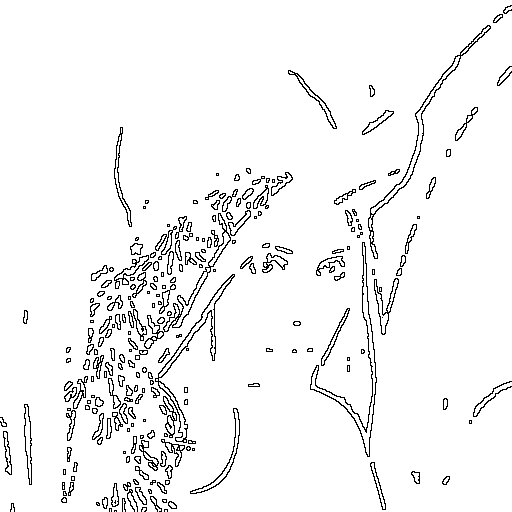

In [9]:
result = zero_crossing(Laplace_Mask1(lena_gray, 15))
cv2_imshow(result)
#cv2.imwrite("Laplace_Mask1_15.bmp", result)
result = zero_crossing(Laplace_Mask2(lena_gray, 15))
cv2_imshow(result)
#cv2.imwrite("Laplace_Mask2_15.bmp", result)
result = zero_crossing(Minimum_variance_Laplacian(lena_gray, 20))
cv2_imshow(result)
#cv2.imwrite("Minimum_variance_Laplacian_20.bmp", result)
result = zero_crossing(Laplacian_of_Gaussian(lena_gray, 3000))
cv2_imshow(result)
#cv2.imwrite("Laplacian_of_Gaussian_3000.bmp", result)
result = zero_crossing(Difference_of_Gaussian(lena_gray, 1))
cv2_imshow(result)
#cv2.imwrite("Difference_of_Gaussian_1.bmp", result)